In [1]:
from speech_pause_indicator import speech, pause ; import setup; import matplotlib.pyplot as plt; import numpy as np

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
##https://pyts.readthedocs.io/en/stable/auto_examples/metrics/plot_dtw.html
from pyts.datasets import load_gunpoint; import math
from pyts.metrics import dtw, itakura_parallelogram, sakoe_chiba_band
from pyts.metrics.dtw import (cost_matrix, accumulated_cost_matrix, _return_path, _blurred_path_region)
import itertools; import statistics

In [3]:
# pyts itakura

def itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech1, speech2):

    method = 'itakura'
    slope = 1.2
    dtw_itakura, path_itakura = dtw(
        x, y, dist='square', method='itakura',
        options={'max_slope': slope}, return_path=True
    )
    parallelogram = itakura_parallelogram(n_timestamps_1, n_timestamps_2,
                                          max_slope=slope)
    matrix_itakura = np.zeros((n_timestamps_1 + 1, n_timestamps_2 + 1))
    for i in range(n_timestamps_1):
        matrix_itakura[i, np.arange(*parallelogram[:, i])] = 0.5
    matrix_itakura[tuple(path_itakura)] = 1.
    path = path_itakura
    dist = dtw_itakura
    normalize_distance(x, y, path, dist, method, am_scale)
    alignment_err(x, y, path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst, time2_lst, xlabel, ylabel, sr, speech_x, speech_y)    
    
    #return path, dist

In [4]:
# pyts sakoechiba

def sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y):
    method = "sakoechiba"
    window_size = 0.1
    dtw_sakoechiba, path_sakoechiba = dtw(
        x, y, dist='square', method='sakoechiba',
        options={'window_size': window_size}, return_path=True
    )
    band = sakoe_chiba_band(n_timestamps_1, n_timestamps_2,
                            window_size=window_size)
    matrix_sakoechiba = np.zeros((n_timestamps_1 + 1, n_timestamps_2 + 1))
    for i in range(n_timestamps_1):
        matrix_sakoechiba[i, np.arange(*band[:, i])] = 0.5
    matrix_sakoechiba[tuple(path_sakoechiba)] = 1.

    path = path_sakoechiba
    dist = dtw_sakoechiba
    normalize_distance(x, y, path, dist, method, am_scale)
    alignment_err(x, y, path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst, time2_lst, xlabel, ylabel, sr, speech_x, speech_y)
    
    # return path, dist

In [5]:
def get_word_xy(smooth_s, smooth_r, time1, seg1_1, seg1_2, time2, seg2_1, seg2_2):
    
    query = smooth_s
    ref = smooth_r
    x = (time1 - seg1_1)/(seg1_2 - seg1_1) * len(query)
    y = (time2 - seg2_1)/(seg2_2 - seg2_1) * len(ref)
    return x, y

# deviation function
def deviation(rho, theta):
    dev = 0
    if rho >= theta and rho <= math.pi/2:
        dev = (rho-theta)/(math.pi/2-theta)
    else:
        dev = (theta - rho)/theta
    return dev

def stretch(path, speech_1, speech_2):
    len_x = max(path[0])
    len_y = max(path[1])
    xs = path[0]
    ys = path[1]
    theta = math.atan(len_y/len_x)    
    numerator = 0
    denominator = 0
    
    stretch_speech = 0
    stretch_pause = 0
    stretch_others = 0
    overall_stretch = 0

    # For 1 point in the warping path x, y
    # xs[i] = index of the point in the original query that dtw uses to align x
    # ys[i] = index of the point in the original reference query that dtw uses to align y                  
    
    # length of path = len(path[0]) = len(path[1])
    for i in range(len(path[0])-1):
        if xs[i+1]-xs[i] == 0:
            rho_i = math.pi/2
        else:
            rho_i = math.atan((ys[i+1]-ys[i]) / (xs[i+1]-xs[i]))

        dev_rho_i = deviation(rho_i, theta)
        numerator = dev_rho_i*math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)
        denominator = denominator + math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)

        sp1 = speech_1[xs[i]]
        sp2 = speech_2[ys[i]]
        
        if sp1 == sp2 == 1: # Add the deviation to either speech, pause, or not aligned
            stretch_speech = stretch_speech + numerator
        elif sp1 == sp2 == 0:
            stretch_pause = stretch_pause + numerator
        else:
            stretch_others = stretch_others+ numerator
            
    overall_stretch = (stretch_speech + stretch_pause + stretch_others)/denominator
    
    return stretch_speech/denominator, stretch_pause/denominator, stretch_others/denominator, overall_stretch

In [15]:
def freq(original_query, start_time, end_time):
    sample_rate, data = wavfile.read(file)
    start_point = int(sample_rate * start_time / 1000)
    end_point = int(sample_rate * end_time / 1000)
    length = (end_time - start_time) / 1000
    counter = 0
    for i in range(start_point, end_point):
        if data[i] < 0 and data[i+1] > 0:
            counter += 1
    return counter/length 

In [16]:
def speech(smooth_query, original_query, seg1_1, seg1_2, samplerate, frame_per_window):
    
    # Take the amplitudes in the 30 ms as the window. Find upper and lower bound
    # Avoid the immediate ms in the beginning of the query because some devices have start sound
    
    abs_q = np.abs(original_query[int(samplerate*0.5): int(samplerate*0.5 + frame_per_window)])
    

    smooth_s = []
    abs_q_len = len(abs_q)
#     print(frame_per_window)
#     print(abs_q_len)
    
    # Rolling average for the first half second: for the upper and lower bound filter
    for i in range(int(abs_q_len)):
        if i < frame_per_window/2:
            i1 = 0 ; i2 = i + int(frame_per_window/2)            
        elif i > (abs_q_len - frame_per_window/2):
            i1 = i - frame_per_window/2 ; i2 = abs_q_len
        else:
            i1 = i-frame_per_window/2 ; i2 = i+frame_per_window/2
        smooth_s.append(np.mean(abs_q[int(i1) : int(i2)]))
    
    # Upper and lower bound of the filter: absolute value of amplitude. Upper and lower refers to the silent amplitude
    
    upper = np.max(smooth_s)
    lower = np.min(smooth_s)
    
    result = []                
    for i in range(len(smooth_query)):
        if np.abs(smooth_query[i]) > upper :
            result.append(1)
        else:
            result.append(0)
                
    return result

In [17]:
def downsample(query, ratio):
    res = []
    for i in range(int(len(query) // ratio)):
        if int(i*ratio) < len(query):
            res.append(query[int(i*ratio)])
    return res

In [18]:
window_len = 30 # Unit: ms
am_scale = 100

def make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr):
    from scipy.io import wavfile 
    capstone_dir = "/Users/ninismacbook/other_docs/Y4S1/capstone" 
    
    file1_path = capstone_dir + "/py_converted/" + file1 ; file2_path = capstone_dir + "/py_converted/" + file2
    
    samplerate, query = wavfile.read(file1_path) ; samplerate, ref = wavfile.read(file2_path)
    ratio = samplerate/sr
    # If input sr = 4410, then ratio = 44100/4410 = 10 (samplerate from py_converted is always 44100)
    
    # Downsample the arrays first
    query_sample = downsample(query, ratio)
    ref_sample = downsample(ref, ratio)
    
    smooth_s = [] # Smoothened sample: entire sample
    smooth_r = [] # smoothened ref
    
    query_s = []
    ref_s = []
    
    # Rolling average on query_sample and ref_sample. Store results in smooth_s, smooth_r
    # The fps here is the new fps after downsampling 
    
    frame_per_window = sr * window_len/1000 # Do smoothening on the query and ref

    for i in range(len(query_sample)):
        if i < frame_per_window/2:
            i1 = 0 ; i2 = i + int(frame_per_window/2)            
        elif i > (len(query_sample) - frame_per_window/2):
            i1 = i - frame_per_window/2 ; i2 = len(query_sample)
        else:
            i1 = i-frame_per_window/2 ; i2 = i+frame_per_window/2
        
        smooth_s.append(np.mean(np.abs(query_sample[int(i1) : int(i2)])))
    
    for i in range(len(ref_sample)):
        if i < frame_per_window/2:
            i1 = 0 ; i2 = i + int(frame_per_window/2)            
        elif i > (len(ref_sample) - frame_per_window/2):
            i1 = i - frame_per_window/2 ; i2 = len(ref_sample)
        else:
            i1 = i-frame_per_window/2 ; i2 = i+frame_per_window/2
        
        smooth_r.append(np.mean(np.abs(ref_sample[int(i1) : int(i2)])))
        
    smooth_s = smooth_s[int(sr*seg1_1): int(sr*seg1_2)]
    smooth_r = smooth_r[int(sr*seg2_1): int(sr*seg2_2)]
        
    query_sample = query[int(sr*seg1_1): int(sr*seg1_2)]
    ref_sample = ref[int(sr*seg2_1): int(sr*seg2_2)]       
    
    # Plot original amplitude graph for first sample

    plot_q = query[int(samplerate*seg1_1): int(samplerate*seg1_2)]
    length1 = len(plot_q) / samplerate
    time1 = np.linspace(0., length1, len(plot_q))    
    plt.figure(figsize=(18.5, 3.5))    
    plt.plot(time1, plot_q)
    
    fig, (ax1, ax2) = plt.subplots(2, 1); fig.set_size_inches(18.5, 3.5)
    
    # Plot the original query and the speech indicator function
    length = len(smooth_s) / samplerate

#     print(len(query_sample), len(ref_sample), len(smooth_s), len(smooth_r), samplerate)   
    
    query_s = speech(smooth_s, query, seg1_1, seg1_2, samplerate, frame_per_window)
    ref_s = speech(smooth_r, ref, seg2_1, seg2_2, samplerate, frame_per_window)     
    
    time = np.linspace(seg1_1, length, len(smooth_s))
    
    ax1.plot(time, smooth_s, color = '#A4A4A4')
    ax2.plot(time, query_s, color = '#A4A4A4');

    plot_r = ref[int(samplerate*seg2_1): int(samplerate*seg2_2)]
    length2 = len(plot_r) / samplerate
    time2 = np.linspace(0., length2, len(plot_r))    
    plt.figure(figsize=(18.5, 3.5))        
    plt.plot(time2, plot_r)
    
    fig, (ax1, ax2) = plt.subplots(2, 1); fig.set_size_inches(18.5, 3.5)
    
    length = len(smooth_r) / samplerate
    time = np.linspace(seg2_1, length, len(smooth_r))
    
    ax1.plot(time, smooth_r, color = '#A4A4A4')
    ax2.plot(time, ref_s, color = '#A4A4A4');    
    
    return plot_q, plot_r, sr, smooth_s, smooth_r, query_s, ref_s

In [19]:
# Original distance / alignment length
# Maximum distance = number of points in the alignment path * largest difference between amplitude of x and y, 
# but this noramlization constant makes the new distance very small

def normalize_distance(x, y, path, dist, method, am_scale):
    plt.figure(figsize=(8, 4.5))                                
    nor_dist = dist / (am_scale * len(path[0]))
    plt.title('dtw %s distance: %.3f' %(method, nor_dist));    
    plt.plot(path[0], path[1]);
    
# unit of distance = amplitude / portion of the alignment path

In [36]:
def alignment_err(x, y, path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst, time2_lst, xlabel, ylabel, sr, speech1, speech2):
    colors = ['red', 'g', 'b', 'm', 'brown', '#d89743', 'grey', 'c', 'orange', 'g', 'b', 'm', 'red']
    err = []
    for i in range(len(time1_lst)):
        x_axis, y_axis = get_word_xy(x, y, time1_lst[i], seg1_1, seg1_2, time2_lst[i], seg2_1, seg2_2)
        
        plt.scatter(x_axis, y_axis, color = colors[i], marker = "X", edgecolor = 'black', s = 100)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
        x_val = list(itertools.chain(*np.where(np.abs(path[0] - x_axis) < 1)))[0]
        y_val = list(itertools.chain(*np.where(np.abs(path[1] - y_axis) < 1)))[0]

        warp_y = path[1][x_val]
        warp_x = path[0][y_val]
        
        e = (np.abs(warp_x - x_axis) + np.abs(warp_y - y_axis))/sr
        err.append(e)    # unit = second
        
    median = statistics.median(err)
    err_sum = sum(err)
    
    print('Avg err (s): %.3f. Median err (s): %.3f' %(err_sum/len(time1_lst), median))
    print('Stretch speech: %.3f \nStretch pause: %.3f. \nStretch unaligned: %.3f. \nStretch overall: %.3f.' %stretch(path, speech1, speech2))

# TORGO: Except in the winter

In [20]:
sr = 8000 ; play_sr = 44100

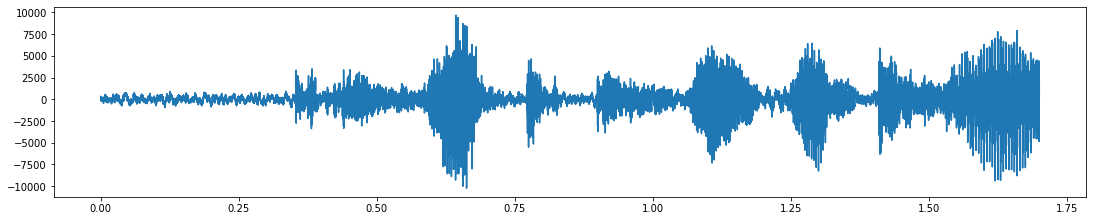

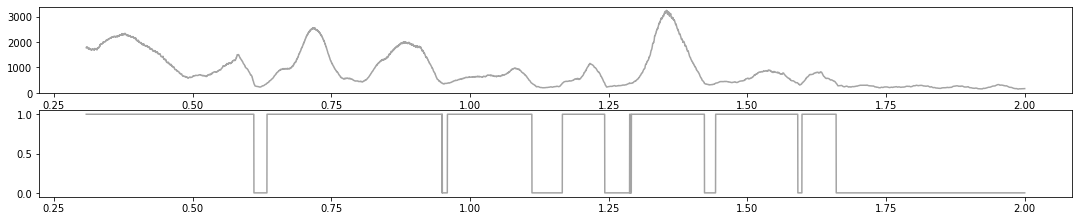

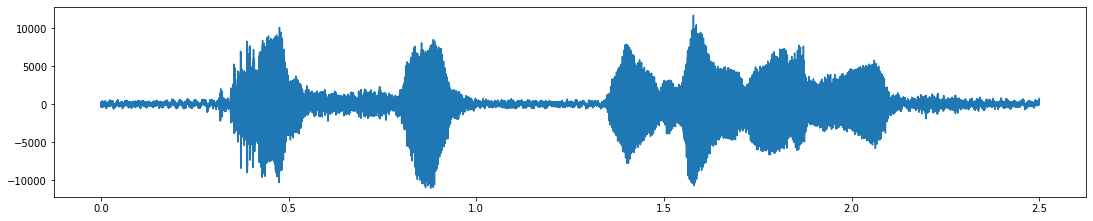

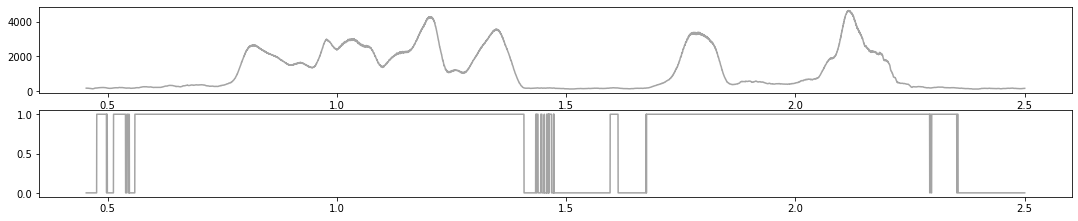

In [21]:
file1, seg1_1, seg1_2 = "torgo-healthy.wav", 2, 3.7
file2, seg2_1, seg2_2 = "torgo-patient.wav", 2.5, 5

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)

n_timestamps_1, n_timestamps_2 = len(x), len(y)

xlabel = "Except in the winter - healthy" ;  ylabel = "Except in the winter - patient"
time1_lst = [2.34, 2.86, 3.03, 3.26] ; time2_lst = [2.8, 3.86, 4.03, 4.20]

In [22]:
# print(len(x), len(y), len(speech_x), len(speech_y))
# setup.play_samples(play_x, play_y, play_sr)

Avg err (s): 0.258. Median err (s): 0.188
Stretch speech: 0.561 
Stretch pause: 0.107. 
Stretch unaligned: 0.123. 
Stretch overall: 0.791.


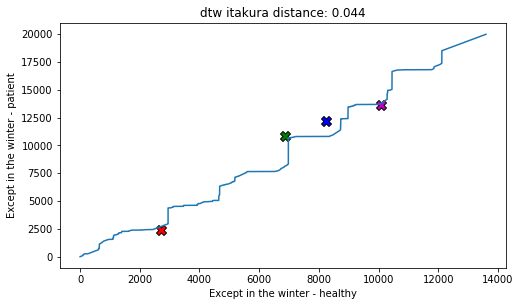

In [37]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.262. Median err (s): 0.198
Stretch speech: 0.571 
Stretch pause: 0.120. 
Stretch unaligned: 0.147. 
Stretch overall: 0.838.


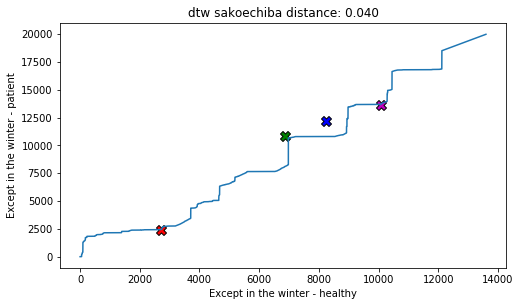

In [38]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Torgo: when the ooze or snow or ice prevents

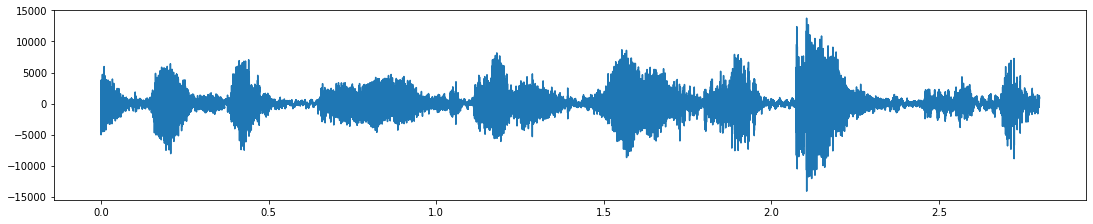

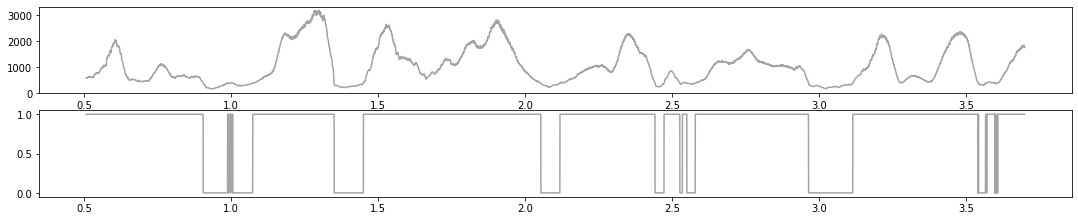

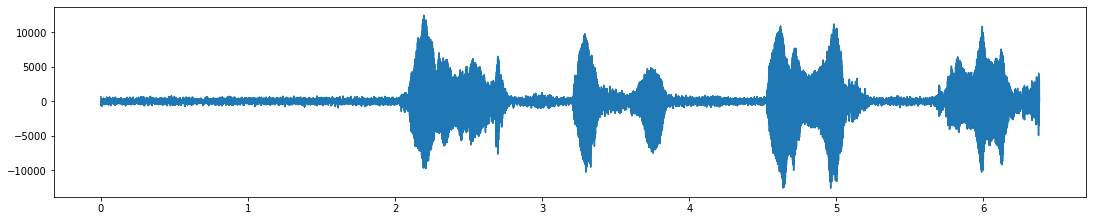

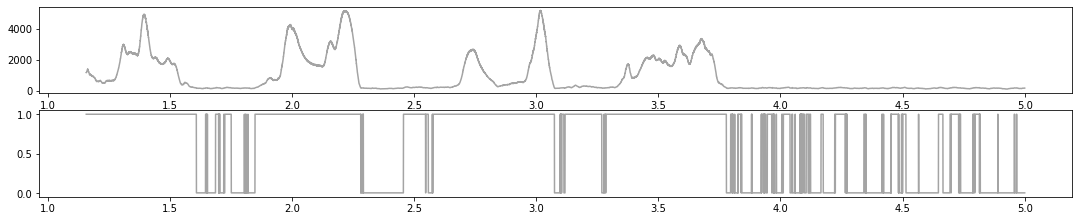

In [39]:
file1, seg1_1, seg1_2 = "torgo-healthy.wav", 3.7, 6.50
file2, seg2_1, seg2_2 = "torgo-patient.wav", 5, 11.38
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.94, 4.03, 4.38, 4.8, 5.1, 5.54, 5.73, 6.18] ;
time2_lst = [7.07, 7.26, 7.78, 8.21, 8.53, 9.57, 9.9, 10.76]
xlabel = "Healthy: when the ooze or snow or ice presents" ;  ylabel = "patient"

In [23]:
# setup.play_samples(play_x, play_y, play_sr)

Avg err (s): 1.262. Median err (s): 1.277
Stretch speech: 0.516 
Stretch pause: 0.164. 
Stretch unaligned: 0.197. 
Stretch overall: 0.878.


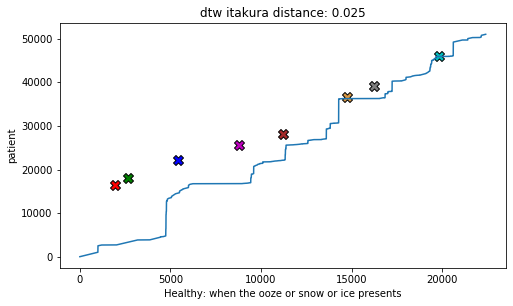

In [40]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 1.323. Median err (s): 1.288
Stretch speech: 0.484 
Stretch pause: 0.238. 
Stretch unaligned: 0.196. 
Stretch overall: 0.918.


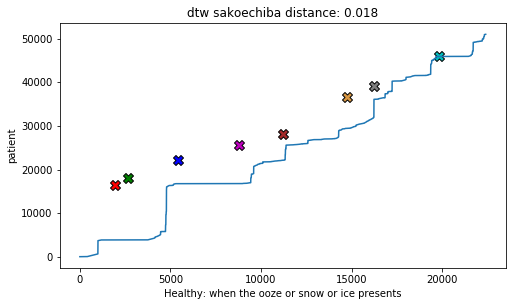

In [41]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Bamboo - perfect alignment - Normal v.s. Normal 01 vs. 01_1 Bamboo walls are getting to be very popular

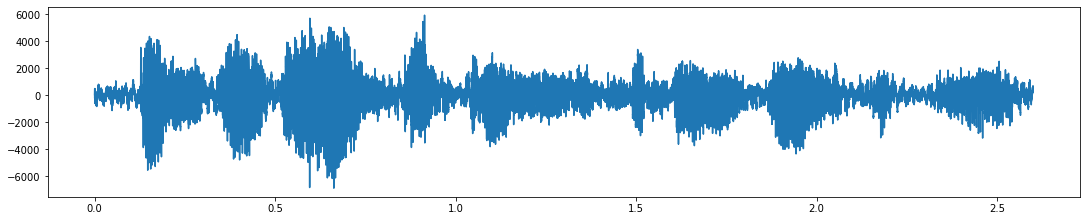

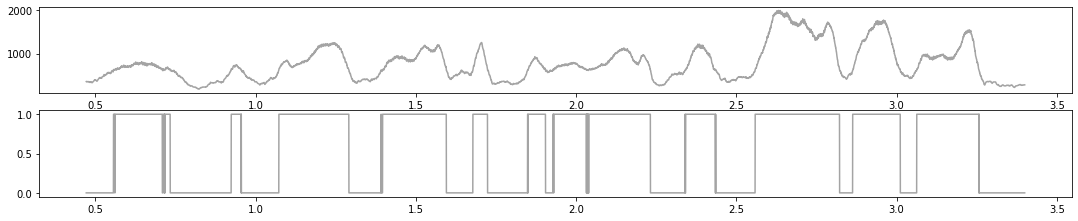

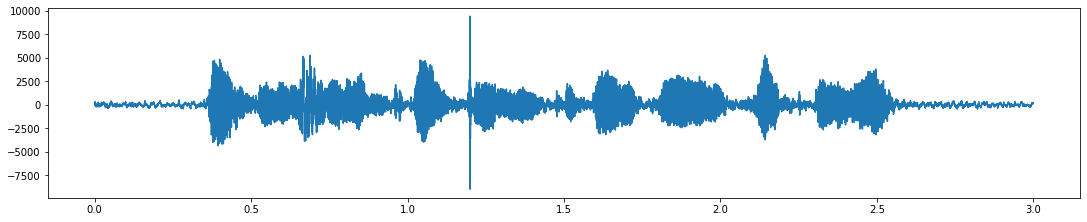

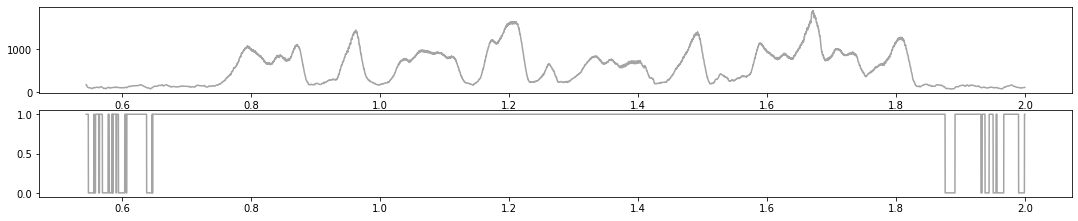

In [42]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_1.wav", 2, 5
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
xlabel = "Bamboo walls are getting to be very popular - Normal 1" ;  ylabel = "Normal 01_1"
time1_lst = [3.46, 3.88, 4.42, 4.77, 4.91, 5.21, 5.47]
time2_lst = [2.33, 2.63, 3.12, 3.4, 3.57, 3.74, 4.06]

In [29]:
# setup.play_samples(play_x, play_y, play_sr)

Avg err (s): 0.289. Median err (s): 0.189
Stretch speech: 0.432 
Stretch pause: 0.008. 
Stretch unaligned: 0.290. 
Stretch overall: 0.729.


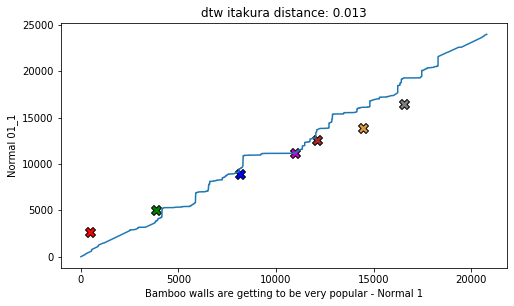

In [43]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.194. Median err (s): 0.153
Stretch speech: 0.455 
Stretch pause: 0.032. 
Stretch unaligned: 0.373. 
Stretch overall: 0.860.


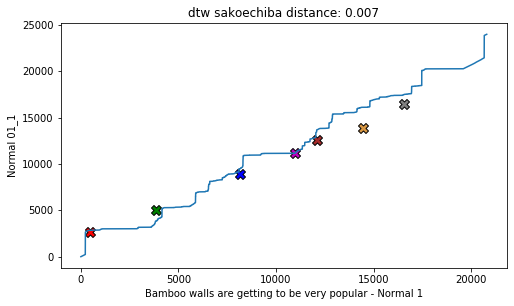

In [44]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Bamboo - perfect alignment - Normal v.s. Normal 01 vs. 01_2

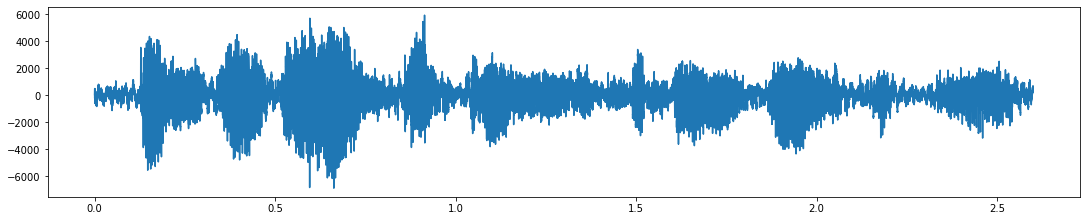

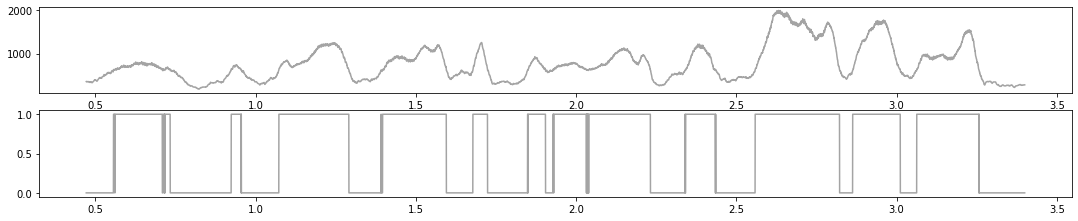

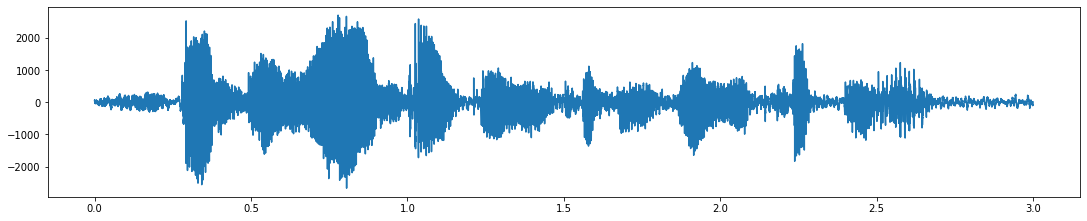

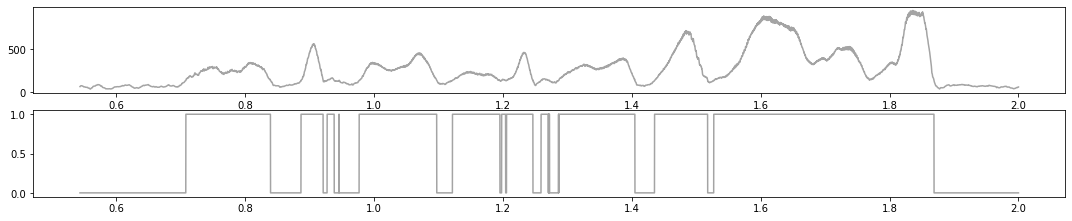

In [45]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_2.wav", 2, 5
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)

xlabel = "Bamboo walls are getting to be very popular - Normal 01" ;  ylabel = "Normal 01_2"
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]

In [46]:
# setup.play_samples(play_x, play_y, play_sr)

Avg err (s): 0.276. Median err (s): 0.294
Stretch speech: 0.246 
Stretch pause: 0.096. 
Stretch unaligned: 0.368. 
Stretch overall: 0.710.


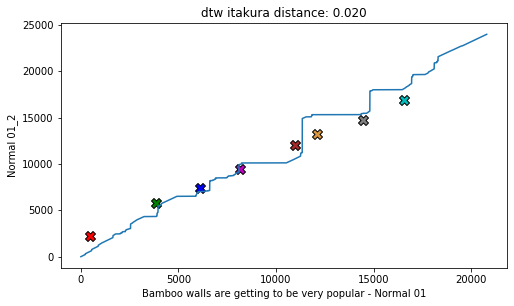

In [47]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.333. Median err (s): 0.356
Stretch speech: 0.294 
Stretch pause: 0.161. 
Stretch unaligned: 0.406. 
Stretch overall: 0.860.


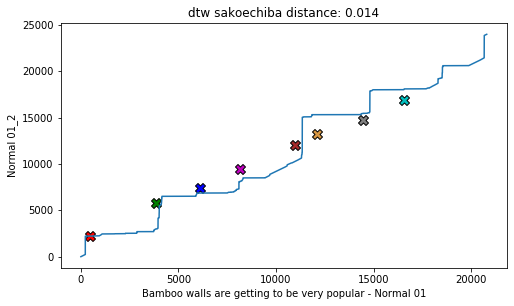

In [48]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Bamboo - perfect alignment - Normal v.s. Normal 01 vs. 01_3

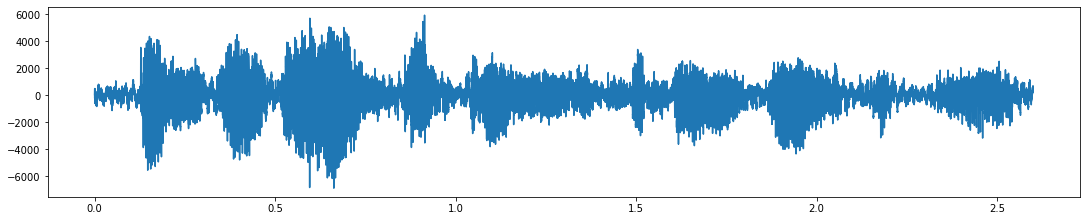

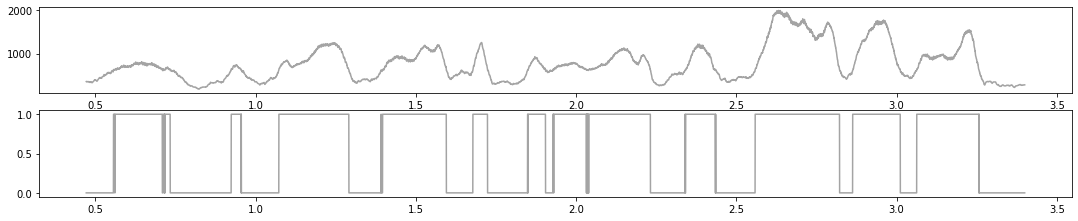

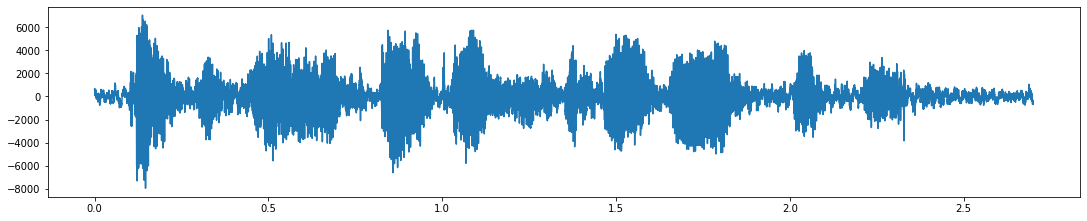

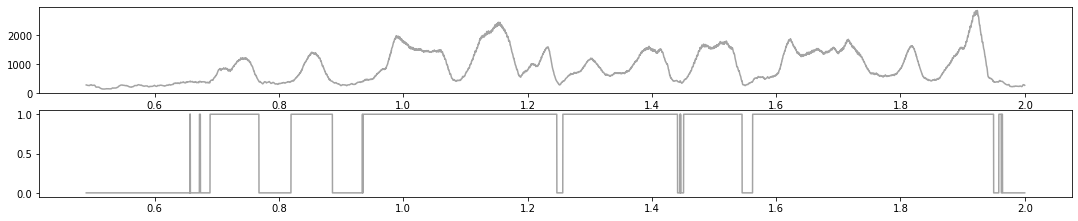

In [49]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)

xlabel = "Bamboo walls are getting to be very popular - Normal 1" ;  ylabel = "Normal 01_3"
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

In [50]:
# setup.play_samples(play_x, play_y, play_sr)

Avg err (s): 0.183. Median err (s): 0.138
Stretch speech: 0.459 
Stretch pause: 0.140. 
Stretch unaligned: 0.107. 
Stretch overall: 0.706.


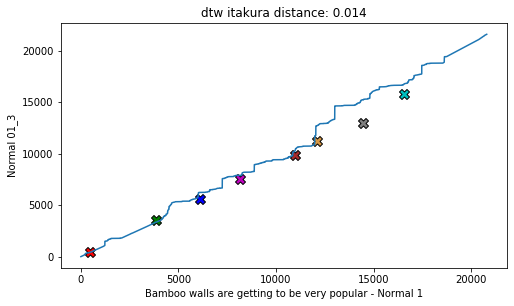

In [51]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.191. Median err (s): 0.138
Stretch speech: 0.495 
Stretch pause: 0.189. 
Stretch unaligned: 0.143. 
Stretch overall: 0.826.


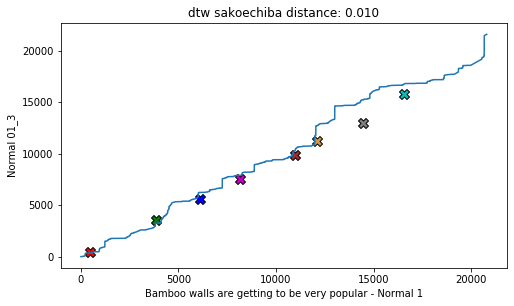

In [52]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Bamboo - perfect alignment - Normal v.s. Normal 01_2 vs. 01_3

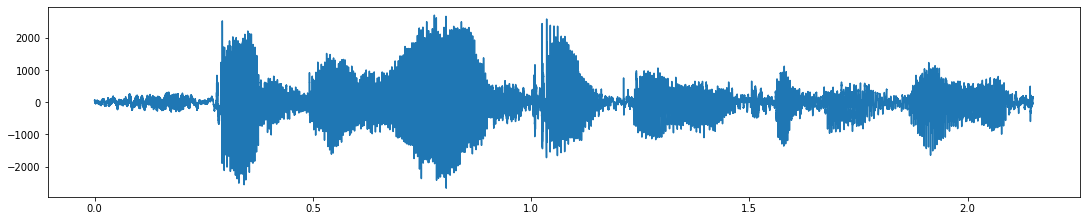

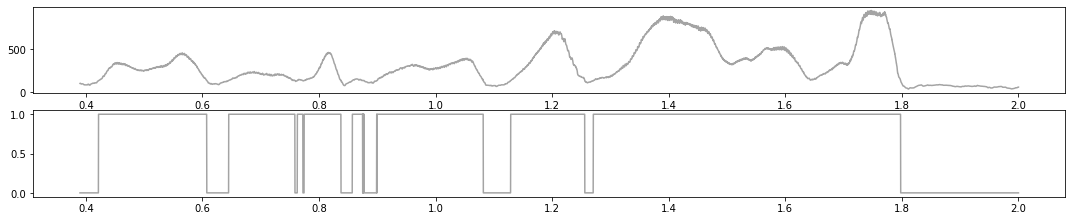

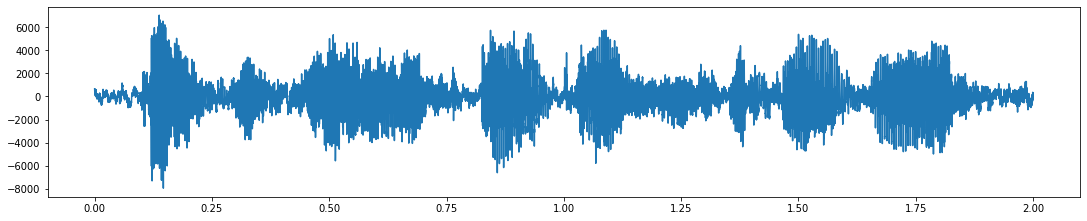

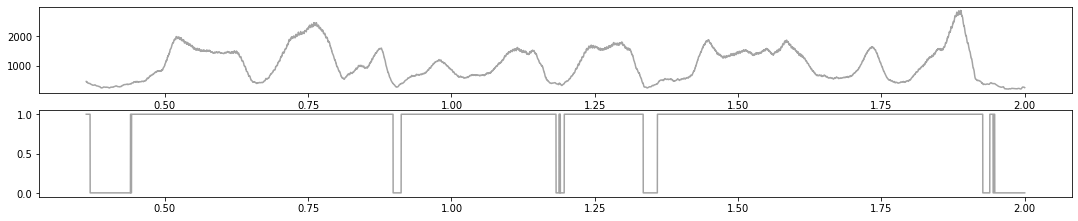

In [53]:
file1, seg1_1, seg1_2 = "01_2.wav", 2, 4.15
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)

xlabel = "Bamboo walls are getting to be very popular - Normal 01_2" ;  ylabel = "Normal 01_3"

time1_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

Avg err (s): 0.324. Median err (s): 0.322
Stretch speech: 0.416 
Stretch pause: 0.033. 
Stretch unaligned: 0.148. 
Stretch overall: 0.596.


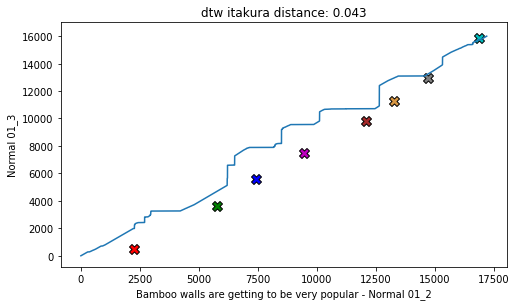

In [54]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.289. Median err (s): 0.291
Stretch speech: 0.566 
Stretch pause: 0.081. 
Stretch unaligned: 0.188. 
Stretch overall: 0.835.


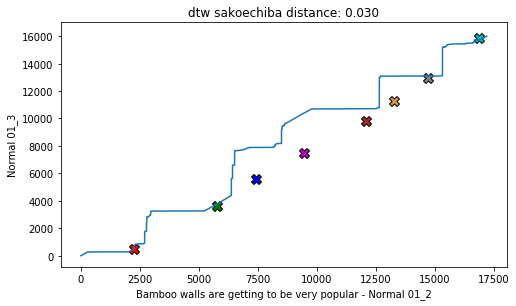

In [55]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Bamboo - perfect alignment - Normal v.s. Normal 01_1 vs. 01_2

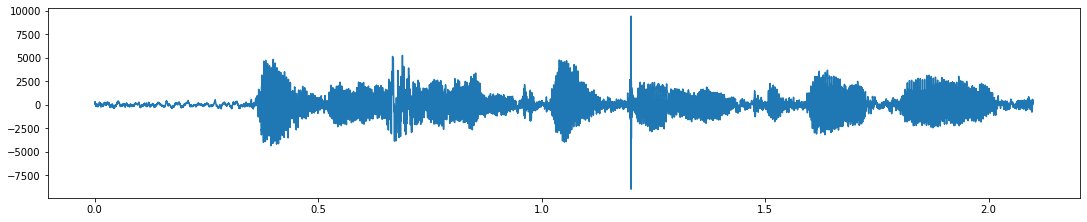

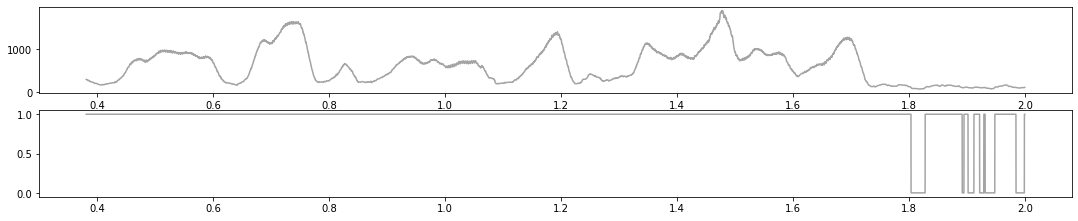

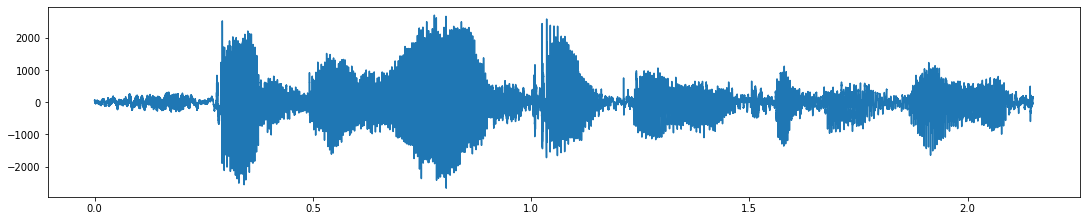

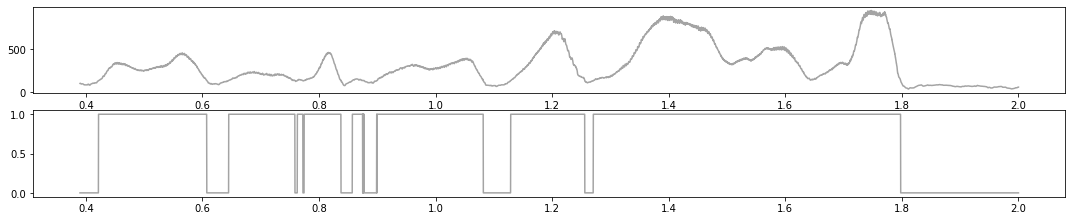

In [56]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 4.1
file2, seg2_1, seg2_2 = "01_2.wav", 2, 4.15
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]

xlabel = "Bamboo walls are getting to be very popular - Normal 01_1" ;  ylabel = "Normal 01_2"

Avg err (s): 0.134. Median err (s): 0.145
Stretch speech: 0.531 
Stretch pause: 0.051. 
Stretch unaligned: 0.079. 
Stretch overall: 0.661.


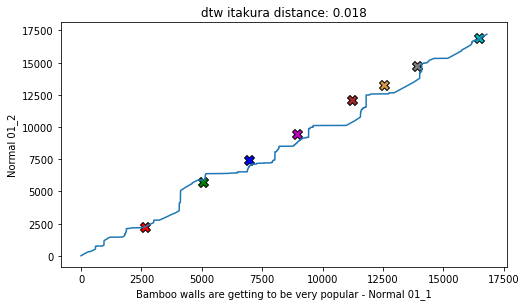

In [57]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.179. Median err (s): 0.188
Stretch speech: 0.729 
Stretch pause: 0.081. 
Stretch unaligned: 0.090. 
Stretch overall: 0.899.


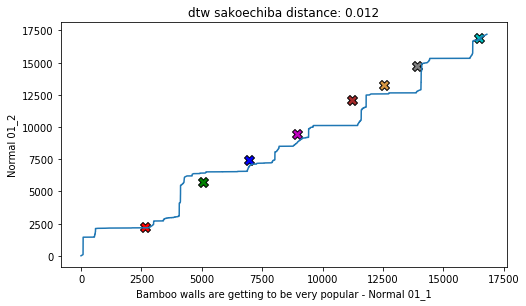

In [58]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Bamboo - perfect alignment - Normal v.s. Normal 01_1 vs. 01_3

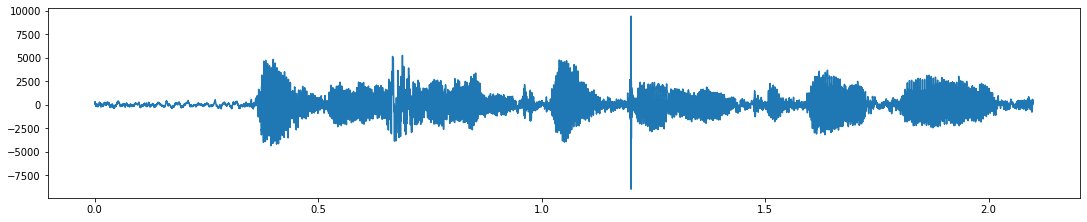

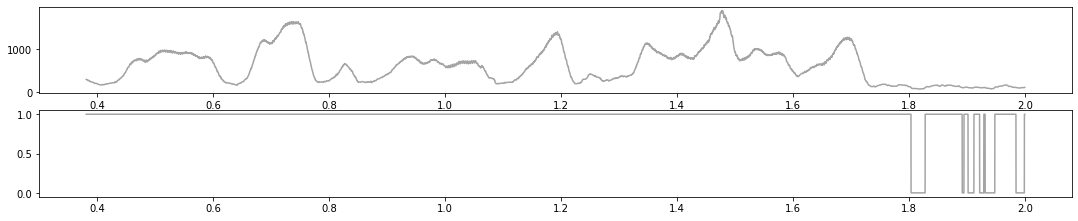

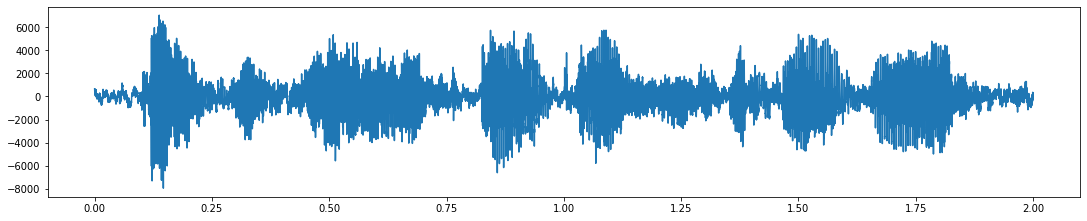

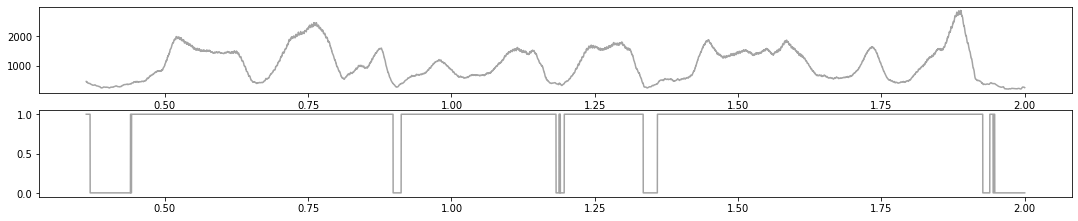

In [59]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 4.1
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];
xlabel = "Bamboo walls are getting to be very popular - Normal 01_1" ;  ylabel = "Normal 01_3"

Avg err (s): 0.269. Median err (s): 0.266
Stretch speech: 0.611 
Stretch pause: 0.002. 
Stretch unaligned: 0.075. 
Stretch overall: 0.688.


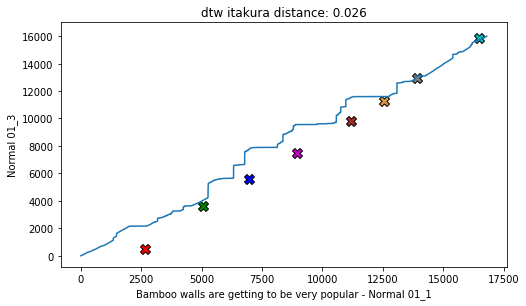

In [60]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.176. Median err (s): 0.099
Stretch speech: 0.609 
Stretch pause: 0.022. 
Stretch unaligned: 0.162. 
Stretch overall: 0.794.


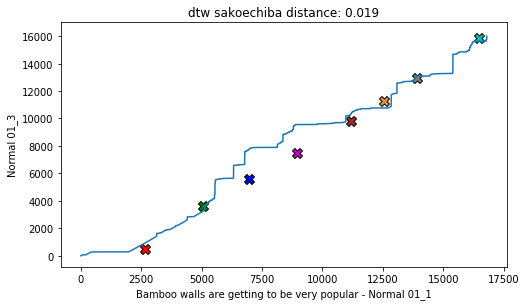

In [61]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Bamboo - normal vs. slightly slow: 01 vs 02: Bamboo walls are getting to be very popular

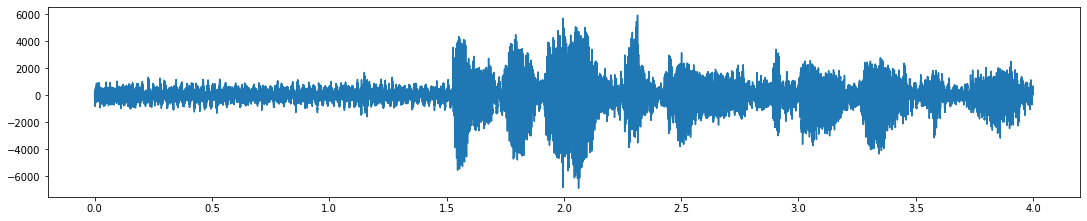

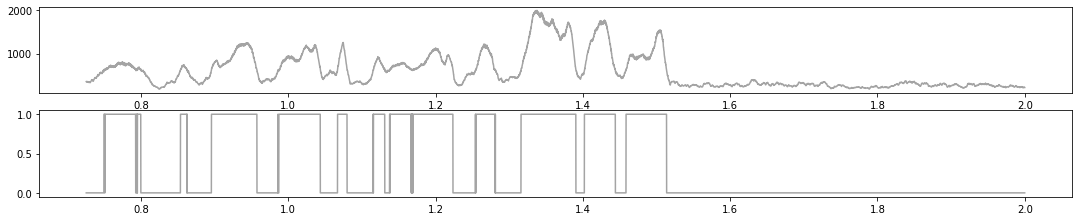

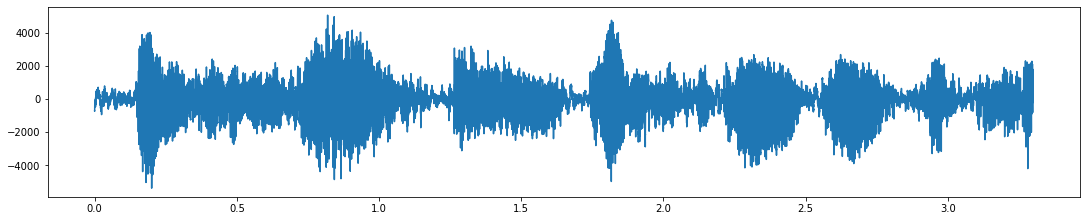

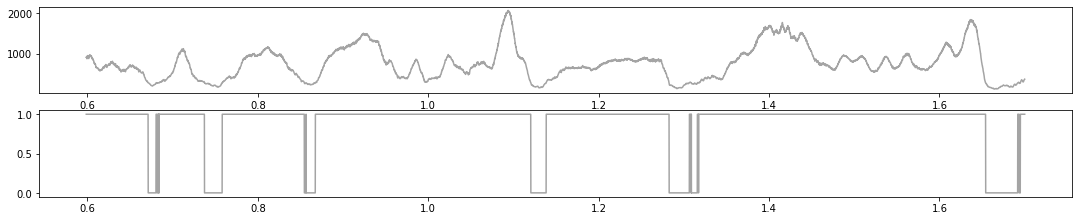

In [62]:
file1, seg1_1, seg1_2 = "01.wav", 2, 6
file2, seg2_1, seg2_2 = "02.wav", 1.7, 5

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [1.74, 2.42, 2.92, 3.52, 3.75, 3.88, 4.29, 4.48]
xlabel = "Bamboo walls are getting to be very popular - Normal 01" ;  ylabel = "Normal 02"

Avg err (s): 0.942. Median err (s): 0.577
Stretch speech: 0.351 
Stretch pause: 0.099. 
Stretch unaligned: 0.292. 
Stretch overall: 0.742.


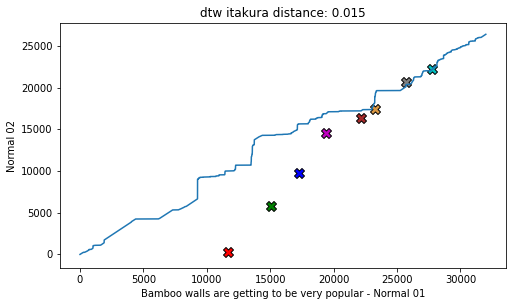

In [63]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.995. Median err (s): 0.577
Stretch speech: 0.335 
Stretch pause: 0.151. 
Stretch unaligned: 0.393. 
Stretch overall: 0.879.


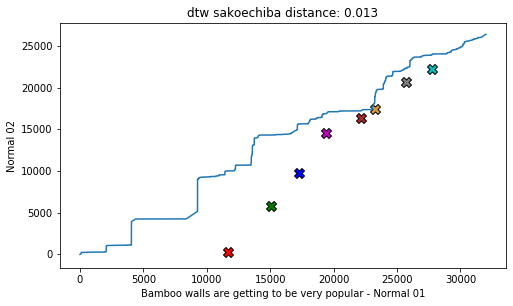

In [64]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Bamboo - normal vs. short pauses: 01 vs 05: Bamboo walls are getting to be very popular

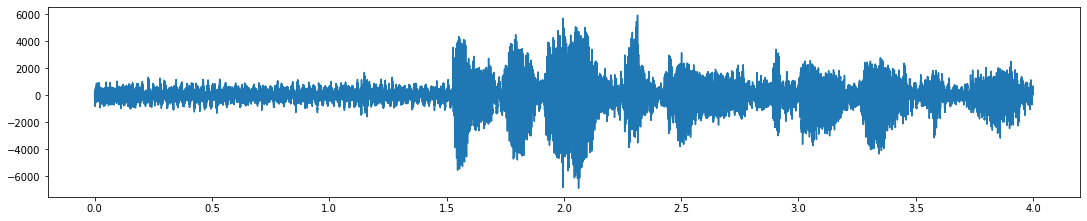

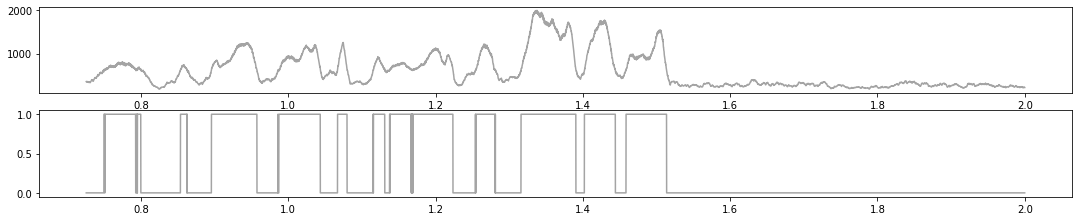

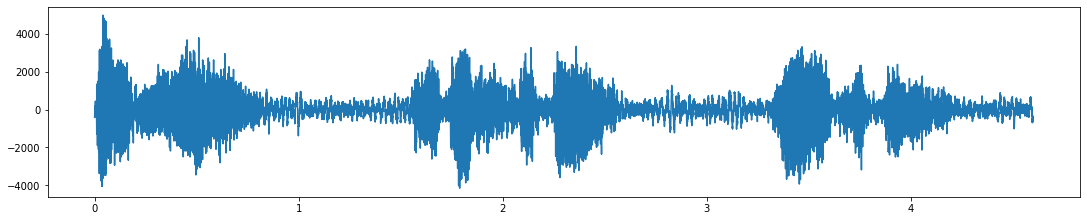

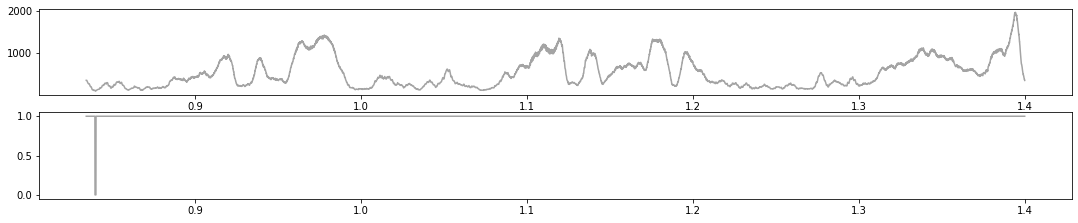

In [65]:
file1, seg1_1, seg1_2 = "01.wav", 2, 6
file2, seg2_1, seg2_2 = "05.wav", 1.4, 6

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] 
time2_lst = [1.45, 1.83, 2.92, 3.17, 3.5, 3.64, 4.78, 5.09]
xlabel = "Bamboo walls are getting to be very popular - 01" ;  ylabel = "05"

In [66]:
# setup.play_samples(play_x, play_y, play_sr)

Avg err (s): 1.779. Median err (s): 1.688
Stretch speech: 0.279 
Stretch pause: 0.000. 
Stretch unaligned: 0.499. 
Stretch overall: 0.778.


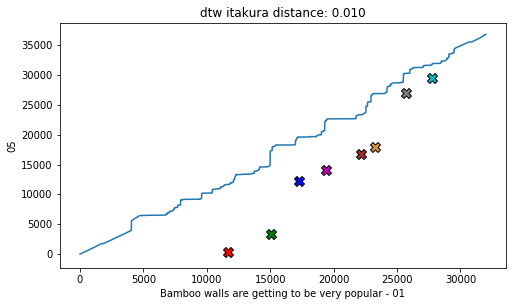

In [67]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 1.771. Median err (s): 1.645
Stretch speech: 0.284 
Stretch pause: 0.001. 
Stretch unaligned: 0.614. 
Stretch overall: 0.898.


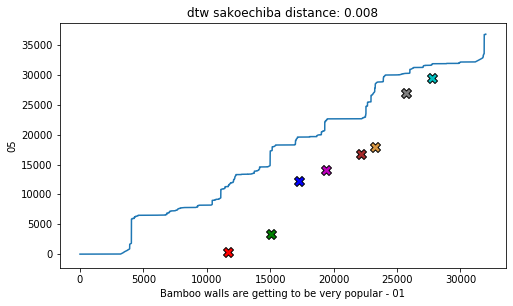

In [68]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Bamboo - normal vs. repeat part of word + pauses: 01 vs pause_m01: Bamboo walls are getting to be very popular

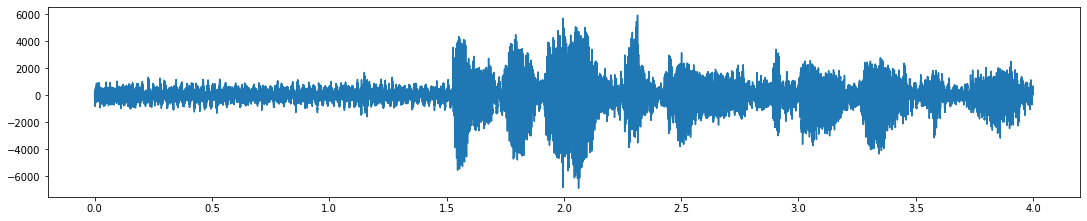

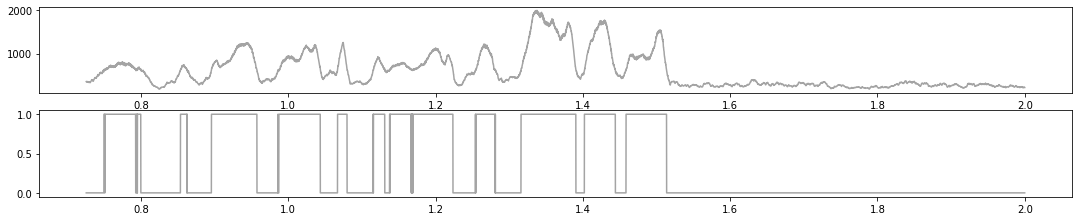

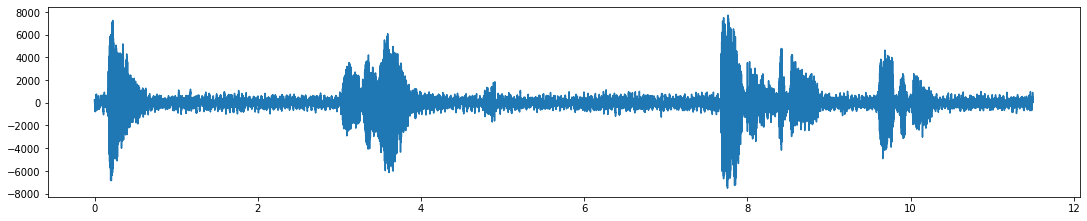

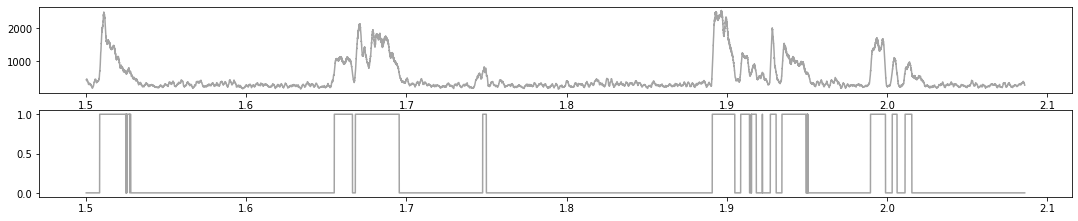

In [69]:
file1, seg1_1, seg1_2 = "01.wav", 2, 6
file2, seg2_1, seg2_2 = "pause_m01.wav", 1.5, 13

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] 
time2_lst = [4.52, 5.11, 9.18, 9.45, 9.82, 9.95, 11.06, 11.30]

xlabel = "Bamboo walls are getting to be very popular - 01" ;  ylabel = file2

In [70]:
# setup.play_samples(play_x, play_y, play_sr)

Avg err (s): 0.550. Median err (s): 0.158
Stretch speech: 0.182 
Stretch pause: 0.692. 
Stretch unaligned: 0.059. 
Stretch overall: 0.933.


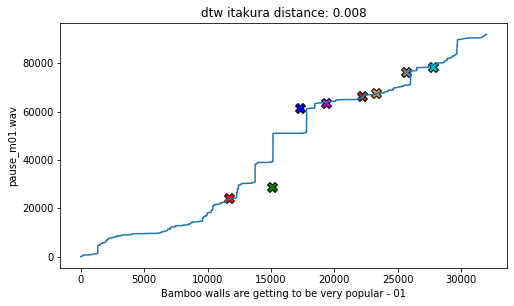

In [71]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

Avg err (s): 0.863. Median err (s): 0.651
Stretch speech: 0.184 
Stretch pause: 0.706. 
Stretch unaligned: 0.055. 
Stretch overall: 0.945.


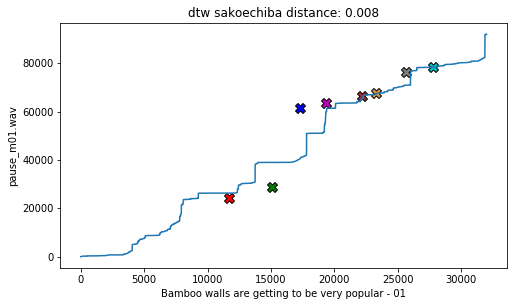

In [72]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Normal vs. slightly faster: 01 vs 01_1: Bamboo walls are getting to be very popular

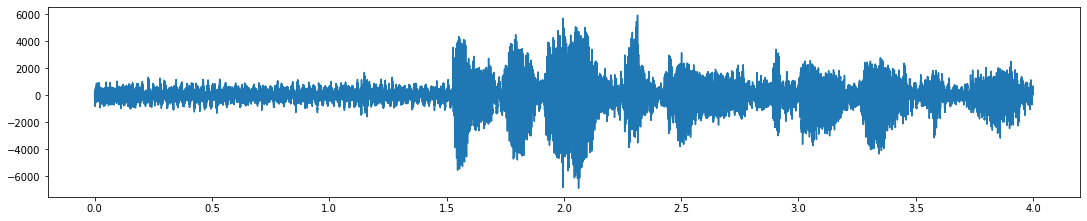

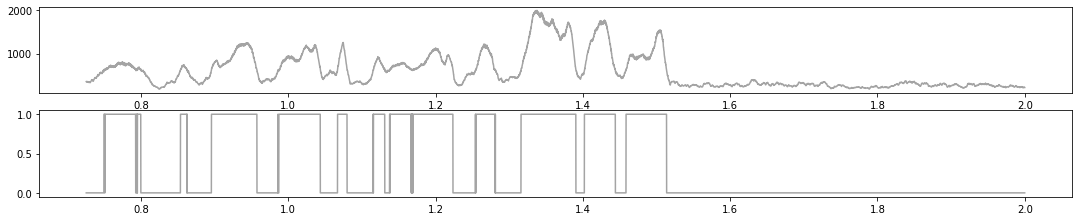

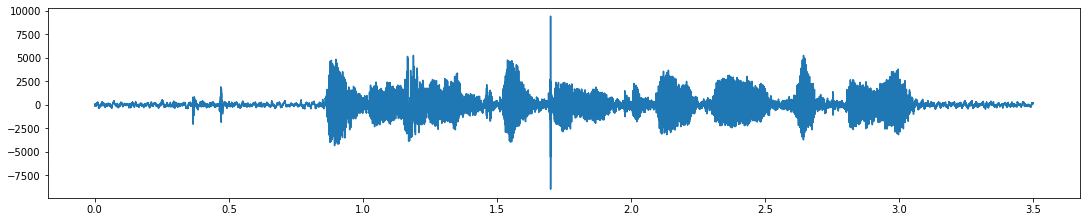

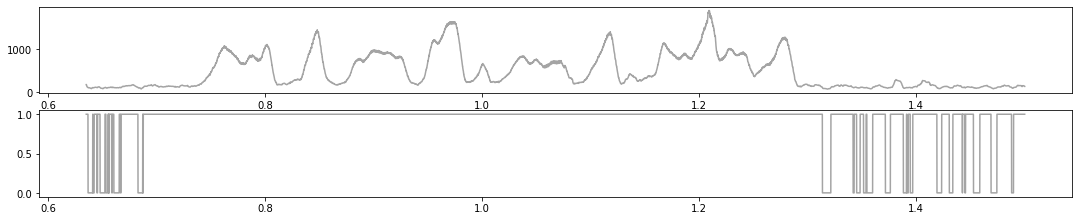

In [73]:
file1, seg1_1, seg1_2 = "01.wav", 2, 6
file2, seg2_1, seg2_2 = "01_1.wav", 1.5, 5

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] 
time2_lst = [2.33, 2.63, 2.87, 3.12, 3.40, 3.57, 3.74, 4.06]

xlabel = "Bamboo walls are getting to be very popular - 01" ;  ylabel = "pause_m01"

In [74]:
# setup.play_samples(play_x, play_y, play_sr)

In [75]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

KeyboardInterrupt: 

In [ ]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Normal vs Stutter 01 vs repeat-syllable01: Bamboo walls are getting to be very popular

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 2, 6
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 1, 7

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] 
time2_lst = [2.97, 3.6, 4.07, 4.30, 4.58, 4.75, 4.98, 6.1]

xlabel = "Bamboo walls are getting to be very popular - 01" ;  ylabel = file2

In [ ]:
# setup.play_samples(play_x, play_y, play_sr)

In [ ]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

In [ ]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Normal vs Stutter 01_1 vs repeat-syllable01: Bamboo walls are getting to be very popular

In [ ]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 4.5
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 1, 7

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.40, 3.57, 3.74, 4.06]
time2_lst = [2.97, 3.6, 4.07, 4.30, 4.58, 4.75, 4.98, 6.1]

xlabel = "Bamboo walls are getting to be very popular - 01" ;  ylabel = file2

In [ ]:
# setup.play_samples(play_x, play_y, play_sr)

In [ ]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

In [ ]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Normal vs Stutter 01_2 vs repeat-syllable01: Bamboo walls are getting to be very popular

In [ ]:
file1, seg1_1, seg1_2 = "01_2.wav", 2, 4.5
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 1, 7

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]
time2_lst = [2.97, 3.6, 4.07, 4.30, 4.58, 4.75, 4.98, 6.1]

xlabel = "Bamboo walls are getting to be very popular - 01" ;  ylabel = file2

In [ ]:
# setup.play_samples(play_x, play_y, play_sr)

In [ ]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

In [ ]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Normal vs Slower: 01 vs 02_1: Bamboo walls are getting to be very popular

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 2, 6
file2, seg2_1, seg2_2 = "02_1.wav", 2.5, 7

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] 
time2_lst = [3.23, 3.90, 4.61, 4.97, 5.27, 5.45, 6.19, 6.57]
xlabel = "Bamboo walls are getting to be very popular - 01" ;  ylabel = file2

In [ ]:
# setup.play_samples(play_x, play_y, play_sr)

In [ ]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

In [ ]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Normal vs Slower: 01_1 vs 02_1: Bamboo walls are getting to be very popular

In [ ]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 4.1
file2, seg2_1, seg2_2 = "02_1.wav", 2.5, 7

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.40, 3.57, 3.74, 4.06]
time2_lst = [3.23, 3.90, 4.61, 4.97, 5.27, 5.45, 6.19, 6.57]
xlabel = "Bamboo walls are getting to be very popular - 01" ;  ylabel = file2

In [ ]:
# setup.play_samples(play_x, play_y, play_sr)

In [ ]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

In [ ]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Normal vs Slower: 01_2 vs 02_1: Bamboo walls are getting to be very popular

In [ ]:
file1, seg1_1, seg1_2 = "01_2.wav", 2, 5
file2, seg2_1, seg2_2 = "02_1.wav", 2.5, 7

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]
time2_lst = [3.23, 3.90, 4.61, 4.97, 5.27, 5.45, 6.19, 6.57]
xlabel = "Bamboo walls are getting to be very popular - 01" ;  ylabel = file2

In [ ]:
# setup.play_samples(play_x, play_y, play_sr)

In [ ]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

In [ ]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Normal vs Slower: 01_3 vs 02_1: Bamboo walls are getting to be very popular

In [ ]:
file1, seg1_1, seg1_2 = "01_3.wav", 2, 4
file2, seg2_1, seg2_2 = "02_1.wav", 2.5, 7

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];
time2_lst = [3.23, 3.90, 4.61, 4.97, 5.27, 5.45, 6.19, 6.57]
xlabel = "Bamboo walls are getting to be very popular - 01" ;  ylabel = file2

In [ ]:
# setup.play_samples(play_x, play_y, play_sr)

In [ ]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

In [ ]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

# Normal vs Slower: 01 vs long_w01: Bamboo walls are getting to be very popular

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 2, 6
file2, seg2_1, seg2_2 = "long_w01.wav", 1.5, 21

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [1.61, 6.12, 8.73, 11.11, 13.33, 15.80, 18.30, 20.72]


xlabel = "Bamboo walls are getting to be very popular - 01" ;  ylabel = file2

In [ ]:
# setup.play_samples(play_x, play_y, play_sr)

In [ ]:
itakura(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)

In [ ]:
sakoechiba(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y)